# Informer + GRU hybrid model

2025-07-25 16:09:39.217242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753459779.437404      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753459779.503260      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-25 16:09:53.262686: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.1075 - loss: 3.0097 - val_accuracy: 0.3097 - val_loss: 2.1665
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4322 - loss: 1.9033 - val_accuracy: 0.7614 - val_loss: 0.9734
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8290 - loss: 0.7817 - val_accuracy: 0.8750 - val_loss: 0.4914
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8969 - loss: 0.4296 - val_accuracy: 0.9119 - val_loss: 0.3126
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9272 - loss: 0.2756 - val_accuracy: 0.9403 - val_loss: 0.1819
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9530 - loss: 0.1759 - val_accuracy: 0.9432 - val_loss: 0.2142
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9451 - loss: 0.1783 - val_accuracy: 0.9602 - val_loss: 0.1345
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9549 - loss: 0.1494 - val_accuracy: 0

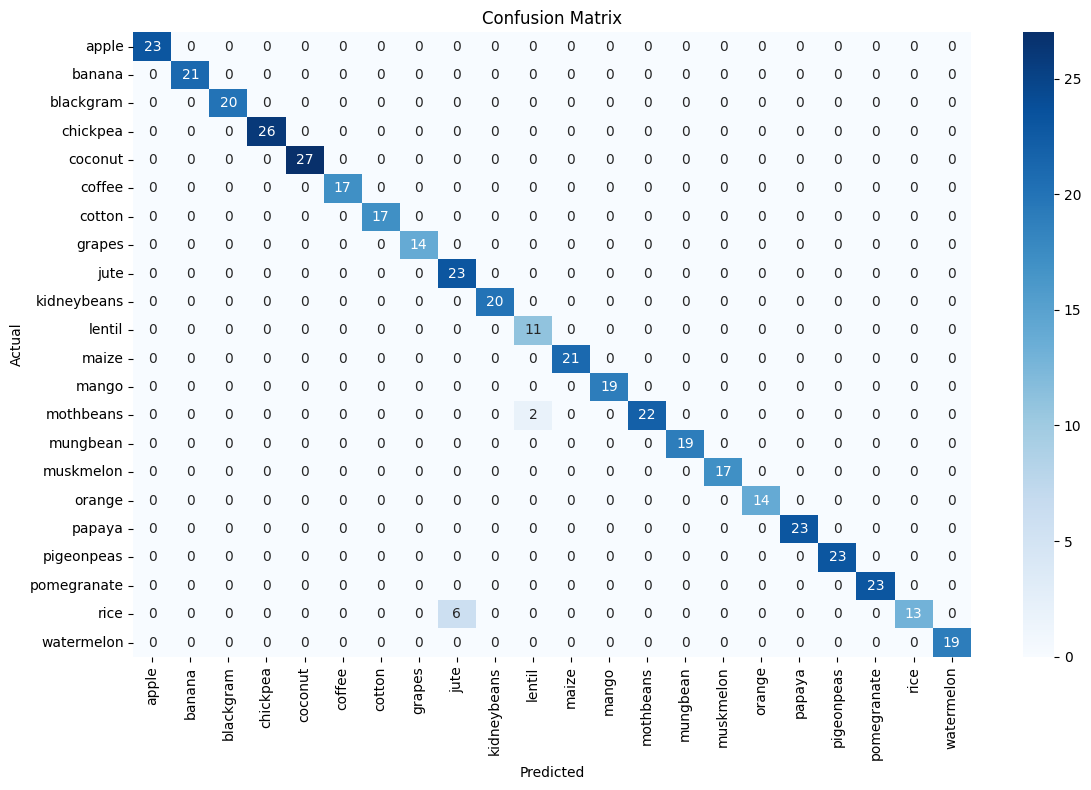

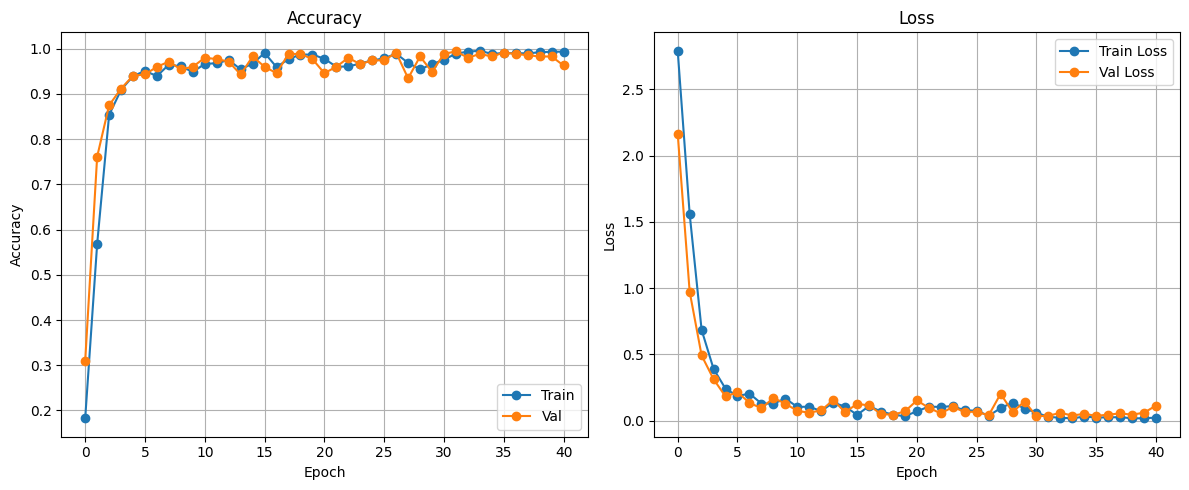

In [1]:
import pandas as pd
import numpy as np
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense, GRU, Dropout, LayerNormalization, Add, Conv1D, Lambda, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess dataset
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features].values
y = df['label'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape((X_scaled.shape[0], 7, 1))  # (samples, features, 1)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

# Informer-like Attention block
def informer_block(x, d_model, num_heads, ff_dim, dropout=0.1):
    # ProbSparse is approximated using standard attention with Conv1D key/value compression
    k = Conv1D(filters=d_model, kernel_size=3, padding='same', activation='relu')(x)
    v = Conv1D(filters=d_model, kernel_size=3, padding='same', activation='relu')(x)
    q = x

    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(q, k, v)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    return x

# Build Informer + GRU model
def informer_gru_model(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, dropout=0.1):
    inp = Input(shape=input_shape)  # (7, 1)

    # Project to d_model dimensions
    x = Conv1D(filters=d_model, kernel_size=1, activation='relu')(inp)

    # Apply multiple Informer blocks
    for _ in range(2):
        x = informer_block(x, d_model, num_heads, ff_dim, dropout)

    # Temporal modeling with GRU
    x = GRU(64, return_sequences=False)(x)

    x = Dropout(dropout)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inp, outputs=out)

# Create and train model
model = informer_gru_model(input_shape=(7, 1), num_classes=y_cat.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stop], verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
